# NFE Project Demonstration Notebook

This notebook overlooks NFE project functionality: GAN, GAN inversion, Image Manipulation, Telegram Bot Interface

## GAN
StyleGAN folder and StyleGAN.ipynb contain model architecture and training, respectively.

### StyleGAN architecture

In [2]:
from StyleGAN import *

In [4]:
Generator()

Generator(
  (style): Sequential(
    (0): EqualLinear(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): EqualLinear(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): EqualLinear(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (5): LeakyReLU(negative_slope=0.2)
    (6): EqualLinear(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (7): LeakyReLU(negative_slope=0.2)
    (8): EqualLinear(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (9): LeakyReLU(negative_slope=0.2)
  )
  (progression): ModuleList(
    (0): StyledConvBlock(
      (conv1): ConstantInput()
      (noise1): NoiseInjection()
      (adain1): AdaptiveInstanceNorm(
        (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (style): Linear

In [5]:
Discriminator()

Discriminator(
  (conv): Sequential(
    (0): EqualConv2d(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvBlock(
      (conv1): Sequential(
        (0): EqualConv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
        (0): Blur()
        (1): EqualConv2d(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (3): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): ConvBlock(
      (conv1): Sequential(
        (0): EqualConv2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
        (0): Blur()
        (1): EqualConv2d(
          (conv): Conv2d(128, 128, kerne

### GAN Images Generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random image from generator!


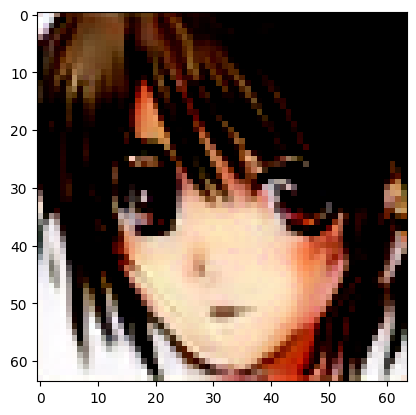

In [3]:
import math
from math import sqrt
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g_path = r".\data\Generator_v2_150.pth"
if g_path is None:
    G = Generator().to(device)
else:
    G = torch.load(g_path, map_location=device)
z = torch.randn(16, 512).to(device)
step = int(math.log(64,2))-2
out = G(z, step=step)


plt.imshow(out[0].permute([1,2,0]).detach().cpu().numpy())
print('Random image from generator!')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random image from generator!


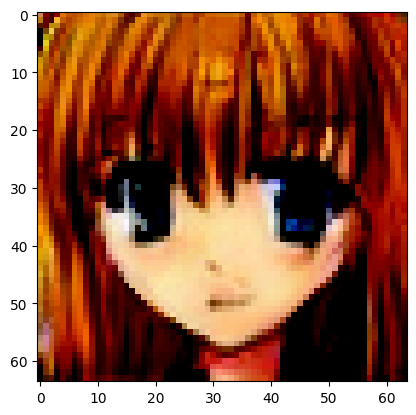

In [12]:
plt.imshow(out[1].permute([1,2,0]).detach().cpu().numpy())
print('Random image from generator!')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random image from generator!


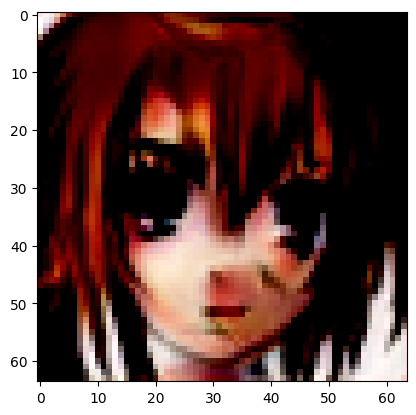

In [13]:
plt.imshow(out[2].permute([1,2,0]).detach().cpu().numpy())
print('Random image from generator!')

In [15]:
d_path = r".\data\Discriminator_v2_150.pth"
if d_path is None:
    D = Discriminator().to(device)
else:
    D = torch.load(d_path, map_location=device)
print('Discriminator score on fake image:')
D(out)

Discriminator score on fake image:


tensor([[0.0218],
        [0.0238],
        [0.0013],
        [0.0046],
        [0.0060],
        [0.9966],
        [0.0813],
        [0.0103],
        [0.1774],
        [0.0283],
        [0.0189],
        [0.0910],
        [0.2640],
        [0.1360],
        [0.1568],
        [0.0148]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### GAN Training plots

See StyleGAN.ipynb for StyleGAN training code and more output!

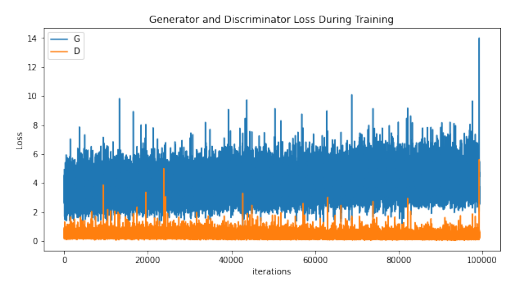

In [25]:
img = plt.imread('gan_training.png')
plt.imshow(img)
plt.axis('off')
plt.show()

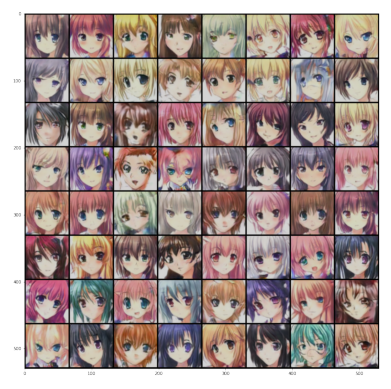

In [27]:
img = plt.imread('gan_output.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### GAN dataset generation

To be able manipulate images, we had to create dataset of our GAN-generated images as shown below and in Data_Generation.ipynb

For presentational pupposes, here we save just 100.

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Function
import torchvision.transforms as transforms
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
from scipy import linalg
from StyleGAN import *
import os

In [12]:
def generate_and_save_random_image(G, index):
    img_size = 64
    step = int(math.log(img_size, 2)) - 2
    z = torch.randn((1, 512), device=device)
    with torch.no_grad():
        img = G(z, step=step)[0]
    imgpath = f'generated_images/random_image_{index}.png'
    imgdata = torch.clip(img, 0, 1).permute([1, 2, 0]).detach().cpu().numpy()
    plt.imsave(imgpath, imgdata)
    return imgpath, z

for i in range(100):
    generate_and_save_random_image(G, i)

print(f'Generated total {len(os.listdir("generated_images"))} images')

Generated total 100 images


## GAN accessment: FID metrics

Fréchet inception distance is metrics introduced by Heusel et al. in 2017 to measure quality of GAN image generation. Below we calculate this metrics to access our GAN. See FID_Calculation.ipynb and Data_Evaluation(FID) for more details.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Function
import torchvision.transforms as transforms
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
from scipy import linalg

In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14834 sha256=dea574bfed5ff95486db5de56bda29203779db4ead6fee562a73ff819d0d5b56
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


## Calculate FID

In [ ]:
import cv2
import glob
for path in glob.glob("images/*"):
  img = cv2.imread(path)
  cv2.imwrite(path, cv2.resize(img, (64, 64)))

In [ ]:
!python -m pytorch_fid /content/images /content/generated_images

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100% 1272/1272 [04:06<00:00,  5.15it/s]
100% 51/51 [00:10<00:00,  5.09it/s]
FID:  55.323972506431005


## GAN Inversion

Also available in GAN_inversion.ipynb as independent notebook.

## GAN Inversion

Also available in GAN_inversion.ipynb as independent notebook.

In [28]:
from bot.inference.gan_inversion_model import *

hi from bot


### GAN Inversion Architecture

In [30]:
ResBlock(5, 4)

ResBlock(
  (conv): Conv2d(5, 4, kernel_size=(1, 1), stride=(1, 1))
  (act): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [31]:
Encoder()

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ResBlock(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (act): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ResBlock(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (act): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): ResBlock(
      (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      (act

In [32]:
E = torch.load(r".\data\Encoder.pth", map_location=device)

### GAN Inversion Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


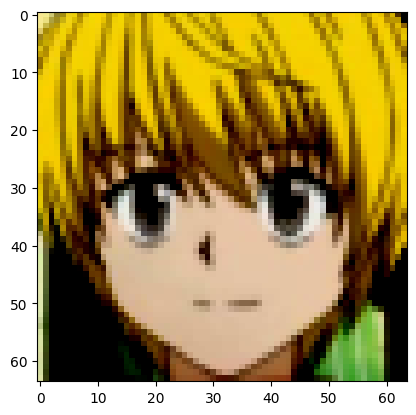

In [34]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image

transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = Image.open("kurapika.jpg").convert("RGB")
img = transform(img).unsqueeze(0)
plt.imshow(img[0].permute([1,2,0]).numpy())

In [35]:
z_dim = 512
step = int(math.log(z_dim, 2)) - 2
img = img.to(device)
with torch.no_grad():
    z = E(img.to(device))
z = torch.clip(z, 0, 1)
z.requires_grad_(True)
z.retain_grad()
lr = 1e-2
optimizer = torch.optim.Adam([z], lr=lr)

criterion = torch.nn.MSELoss(reduction="sum")
losses = []
epochs = 1000
f = torchvision.transforms.functional.gaussian_blur
for i in range(epochs):
    optimizer.zero_grad()

    out = G(z, step=step)

    loss = criterion(f(out, 3, 11.0), f(img, 3, 11.0)) + 20.0 * torch.norm(z, p=2.0)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        print("iter {:04d}: y_error = {:03g}".format(i,
                                                     loss.item()))

iter 0000: y_error = 3182.64
iter 0020: y_error = 1586.74
iter 0040: y_error = 1352.5
iter 0060: y_error = 1263.29
iter 0080: y_error = 1206.69
iter 0100: y_error = 1174.6
iter 0120: y_error = 1147.66
iter 0140: y_error = 1119.01
iter 0160: y_error = 1089.32
iter 0180: y_error = 1069.96
iter 0200: y_error = 1049.11
iter 0220: y_error = 1023.72
iter 0240: y_error = 1004.16
iter 0260: y_error = 981.463
iter 0280: y_error = 954.113
iter 0300: y_error = 932.509
iter 0320: y_error = 902.387
iter 0340: y_error = 886.802
iter 0360: y_error = 869.175
iter 0380: y_error = 849.401
iter 0400: y_error = 826.039
iter 0420: y_error = 801.217
iter 0440: y_error = 772.703
iter 0460: y_error = 759.742
iter 0480: y_error = 737.358
iter 0500: y_error = 720.815
iter 0520: y_error = 705.955
iter 0540: y_error = 688.493
iter 0560: y_error = 679.014
iter 0580: y_error = 654.09
iter 0600: y_error = 640.792
iter 0620: y_error = 627.615
iter 0640: y_error = 616.405
iter 0660: y_error = 606.24
iter 0680: y_error

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


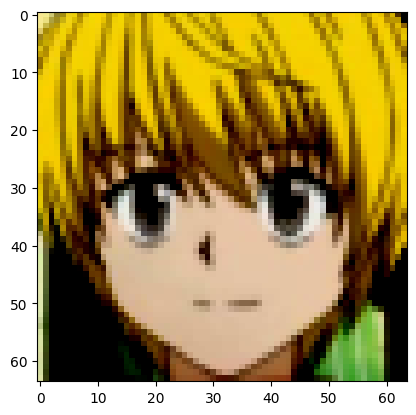

In [38]:
res = G(z, step=step)
plt.imshow(img[0].permute([1, 2, 0]).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


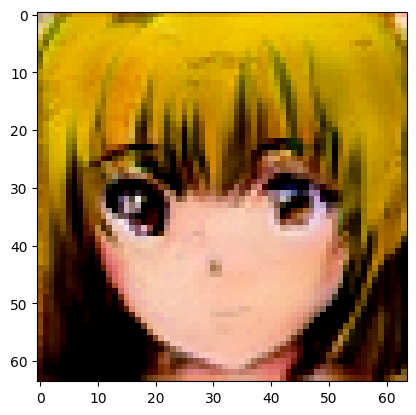

In [39]:
plt.imshow(res[0].permute([1,2,0]).detach().cpu())

## Image Manipulation

Full version & SVM training is available in tagging.ipynb, manipulate.ipynb

In [54]:
import warnings

warnings.filterwarnings("ignore")
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from StyleGAN import *
import torch
import math
import os
import pickle
import random

### Load pretrained SVM.

SVM training is in manipulate.ipynb

In [55]:
properties = ["hair", "hair_length", "eyes"]
feature2svm = {}
class2value = {}
dataroot = "data"
path = os.path.join(dataroot, "attributes.csv")
attributes = pd.read_csv(path)
property_to_options = {}
for i in properties:
    filename = f'svm_{i}.sav'
    svm = pickle.load(open(os.path.join(dataroot, filename), 'rb'))
    feature2svm[i] = svm
    y = attributes[~attributes[i].isna()][i]
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    class2value[i] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

def get_conditional_boundary(boundary, preserved_features=None):
    """
    make the hyperplane orthogonal to hyperplanes of specified features
    :param boundary: hyperplane of the feature to be changed
    :param preserved_features: list of feature names to be preserved
    :return: modified separating hyperplane
    """
    if preserved_features is None:
        return boundary / np.linalg.norm(boundary)
    cond = []
    for feature in preserved_features:
        cond.append(feature2svm[feature].coef_)
    cond = np.vstack(cond)
    A = np.matmul(cond, cond.T)
    B = np.matmul(cond, boundary.T)
    x = np.linalg.solve(A, B)
    new = boundary - (np.matmul(x.T, cond))
    return new / np.linalg.norm(new)

def manipulate(z, feature, value, preserved_features=None, start=-3.0, end=3.0, steps=7, z_dim=512):
    """
    Manipulate the image in the desired attribute
    :param z: latent code to be manipulated
    :param feature: feature to be changed
    :param value: desired target value of the feature
    :param preserved_features: features to be preserved
    :param start: The distance to the boundary where the manipulation starts
    :param end: The distance to the boundary where the manipulation ends
    :param steps: Number of manipulation steps between start and end
    :param z_dim: dimensionality of latent vector
    :return: list of manipulated latent vectors
    """
    if not os.path.exists(os.path.join('data', f'svm_{feature}.sav')):
        raise AssertionError('No svm found')
        vectors = np.loadtxt(os.path.join(root, "vectors.csv"), delimiter=",")
        svm = get_boundary(vectors, attributes, feature)
    else:
        svm = feature2svm[feature]
    if len(z.shape) == 1:
        z = z.reshape((-1, z_dim))
    init_value = svm.predict(z)[0]
    value = class2value[feature][value]
    if value == init_value:
        value = random.choice([i for i in range(len(class2value[feature])) if i != init_value])
    boundary_idx = 0
    boundary_idx += sum([len(class2value[feature]) - i - 1 for i in range(min(init_value, value))])
    boundary_idx += abs(init_value - value) - 1
    boundary = get_conditional_boundary(svm.coef_[boundary_idx], preserved_features)
    linspace = np.linspace(start, end, steps) - z.dot(boundary.T)
    return z + linspace.reshape(steps, 1) * boundary.reshape(1, -1)

### Unconditional Manipulation

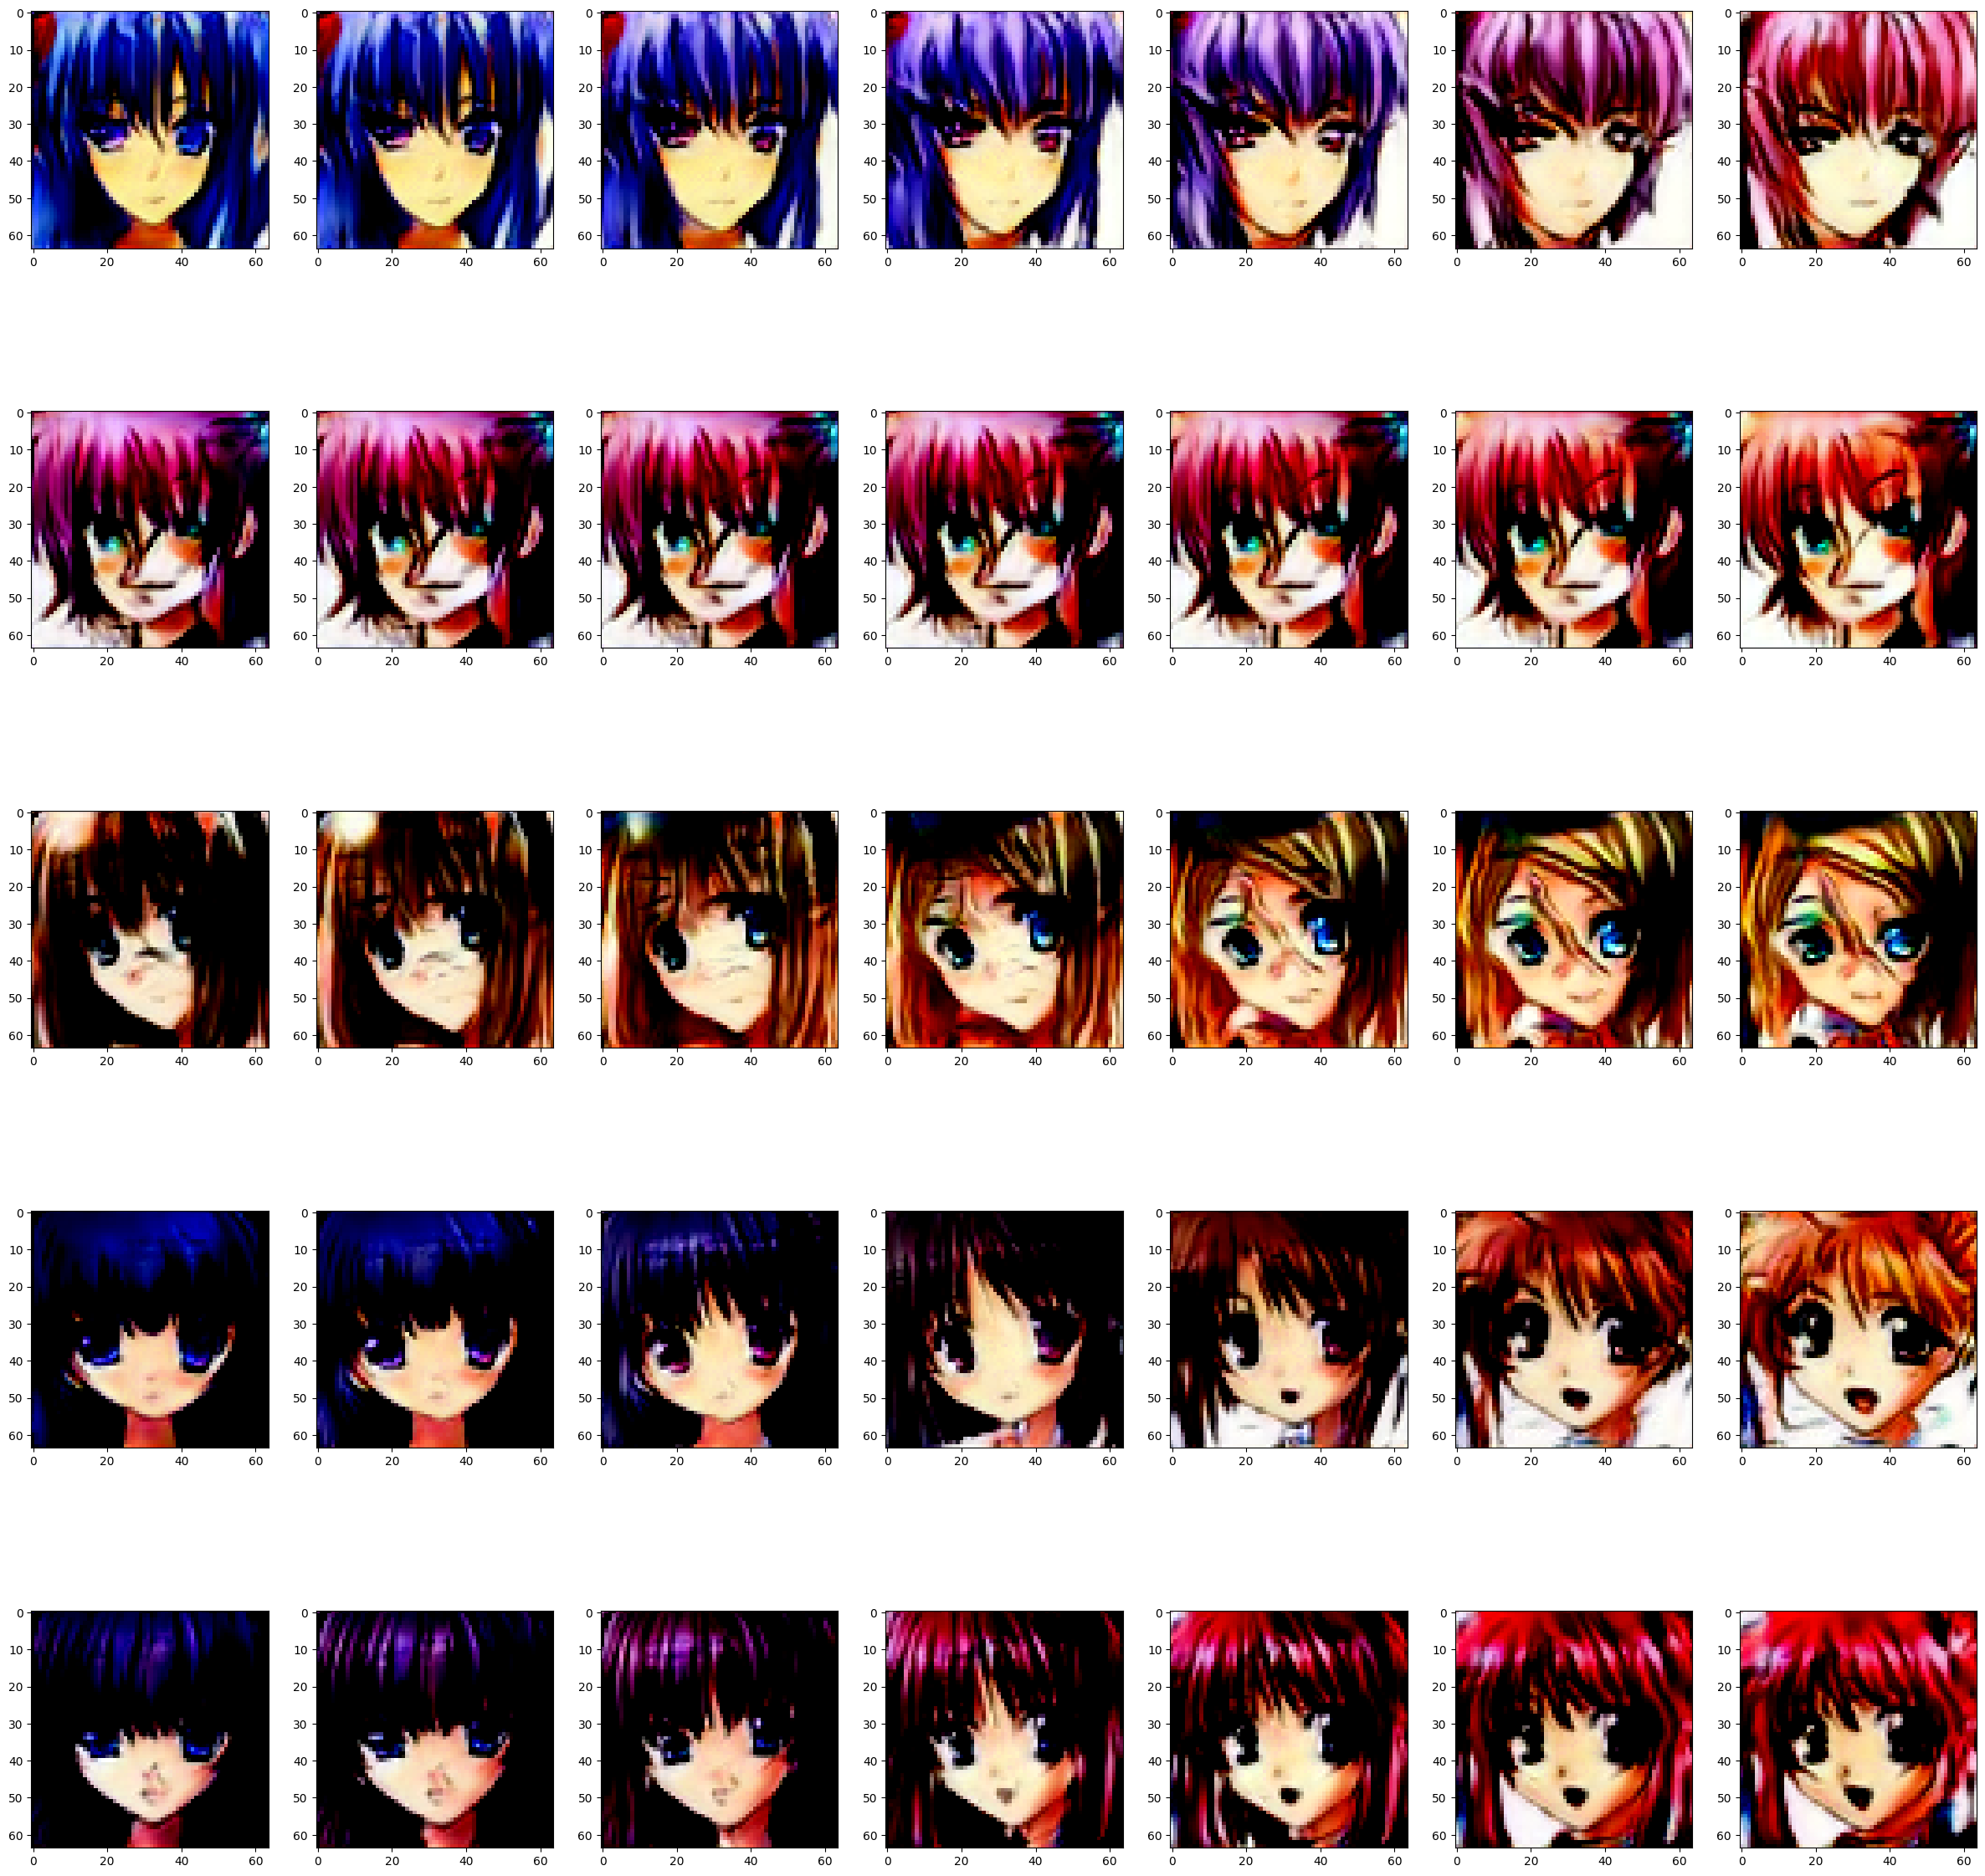

In [57]:
step = int(math.log(512,2))-2
fig, axs = plt.subplots(5,7, figsize=(30,30))

for idx in range(5):
  z_0 = np.random.randn(512)
  z_s = manipulate(z_0, "hair_length", "short", start=-5.0, end=5.0)
  for i, z in enumerate(z_s):
    out = G(torch.tensor(z).to(device).view(1,-1).float(), step=step)
    img = out[0].permute([1,2,0]).detach().cpu().numpy()
    img = np.clip(img, 0, 1)
    axs[idx, i].imshow(img)

### Conditional Manipulation

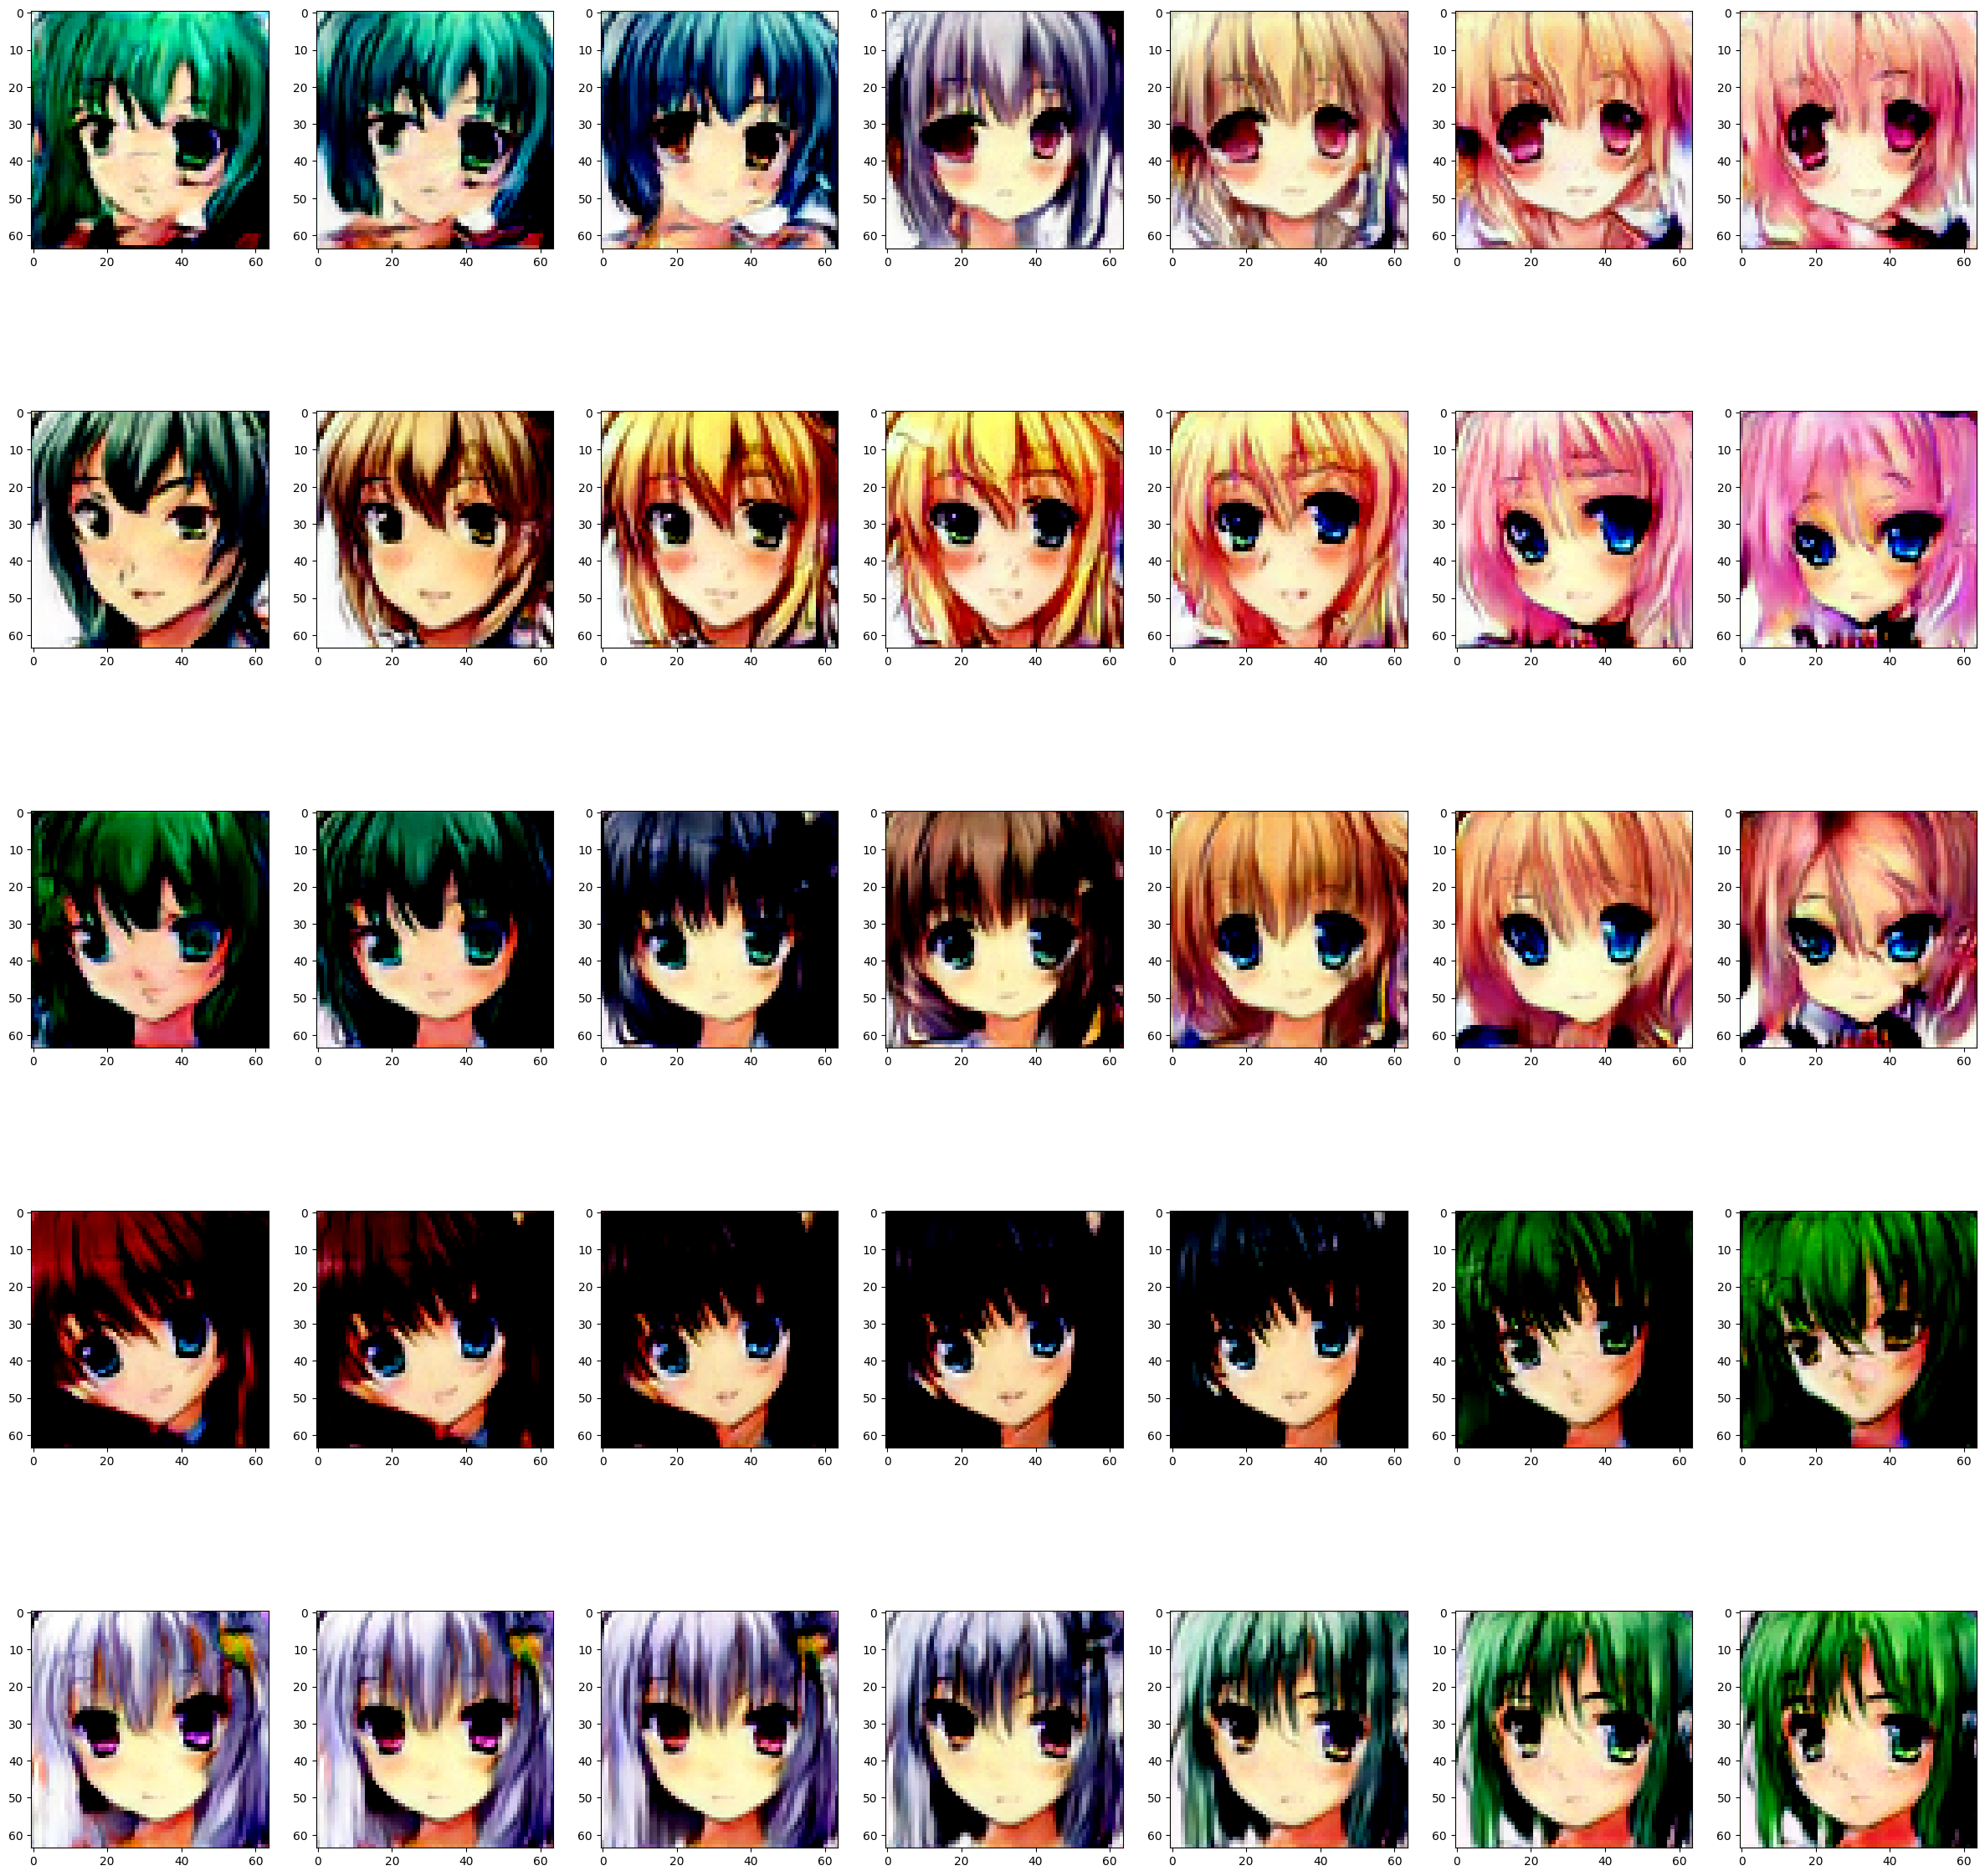

In [58]:
step = int(math.log(512,2))-2
fig, axs = plt.subplots(5,7, figsize=(30,30))

for idx in range(5):
    z_0 = np.random.randn(512)
    z_s = manipulate(z_0, "hair", "green", ["hair_length", "eyes"], start=-5.0, end=5.0)
    for i, z in enumerate(z_s):

        out = G(torch.tensor(z).to(device).view(1,-1).float(), step=step)
        img = out[0].permute([1,2,0]).detach().cpu().numpy()
        img = np.clip(img, 0, 1)
        axs[idx, i].imshow(img)

Look for more changes in manipulate.ipynb!

## Telegram Bot Functionality

Finally, we list several screenshots from manipulation with our @neural_face_editor_bot. Try it our yourself!

![GAN Face Generation](images/show_face.png)

![Face manipulation start](images/show_change.png)

![Face manipulation attribute selection](images/show_changemid.png)

![Face Manipulation Result](images/show_changefinal.png)

![GAN Inversion](images/show_gan_inversion.png)